In [1]:
# Step 1: Load Data
import pandas as pd
from itertools import combinations
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx

# Load the data
file_path = 'Goodreads_books_with_genres.csv'
data = pd.read_csv(file_path)

# Step 2: Preprocess Data
# Extract relevant columns
genres = data['genres']
ratings = data['average_rating']

# Create sets of genres for each book
genre_lists = [set(str(g).split(';')) if isinstance(g, str) else set() for g in genres]

# Step 3: Calculate Metrics
# Helper function to calculate genre co-occurrences (edges)
def calculate_genre_edges(genre_lists):
    genre_edges = defaultdict(int)
    for genre_list in genre_lists:
        for genre1, genre2 in combinations(genre_list, 2):
            genre_edges[tuple(sorted([genre1, genre2]))] += 1
    return genre_edges

# Calculate edges for the full dataset
genre_edges = calculate_genre_edges(genre_lists)


# Step 4: Create Network
genre_network = nx.Graph()
for (genre1, genre2), weight in genre_edges.items():
    genre_network.add_edge(genre1, genre2, weight=weight)

# Step 5: Calculate Additional Metrics
# Degree distribution
degree_distribution = [degree for _, degree in genre_network.degree()]

# Edge weight distribution
edge_weights = [data['weight'] for _, _, data in genre_network.edges(data=True)]


# Calculate unique genres (nodes)
unique_genres = set().union(*genre_lists)
num_genres = len(unique_genres)

# Total edges
total_edges = len(genre_edges)

# Possible edges (nC2)
possible_edges = num_genres * (num_genres - 1) / 2
network_density = total_edges / possible_edges


# Display key metrics
metrics_summary = {
    "Number of Nodes (Genres)": num_genres,
    "Number of Edges (Genre Pairs)": total_edges,
    "Network Density": network_density,
}
metrics_summary


{'Number of Nodes (Genres)': 890,
 'Number of Edges (Genre Pairs)': 27051,
 'Network Density': 0.06837881219903692}

In [4]:

largest_cc = max(nx.connected_components(genre_network), key=len)
subgraph = genre_network.subgraph(largest_cc)


nodes_df = pd.DataFrame({
    'Id': list(subgraph.nodes()),
    'Degree': [degree for _, degree in subgraph.degree()],
    'Betweenness': nx.betweenness_centrality(subgraph).values(),
    'Closeness': nx.closeness_centrality(subgraph).values(),
    'Eigenvector': nx.eigenvector_centrality(subgraph).values(),
})

# Export Nodes
nodes_df.to_csv('nodes.csv', index=False)

# Export Edges for the subgraph
edges_df = pd.DataFrame([
    {'Source': u, 'Target': v, 'Weight': data['weight']}
    for u, v, data in subgraph.edges(data=True)
])
edges_df.to_csv('edges.csv', index=False)

print("Network data for the largest connected component exported as 'nodes.csv' and 'edges.csv'.")


Network data for the largest connected component exported as 'nodes.csv' and 'edges.csv'.


In [2]:
import pandas as pd
from itertools import combinations
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx

# Load the data
file_path = 'Goodreads_books_with_genres.csv'
data = pd.read_csv(file_path)

# Step 2: Preprocess Data
# Extract relevant columns
genres = data['genres']
ratings = data['average_rating']
data_filtered = data[(ratings >= 3.5) & (ratings <= 4)]

# Create sets of genres for each book
genre_lists = [set(str(g).split(';')) if isinstance(g, str) else set() for g in data_filtered['genres']]

# Step 3: Calculate Metrics
# Helper function to calculate genre co-occurrences (edges)
def calculate_genre_edges(genre_lists):
    genre_edges = defaultdict(int)
    for genre_list in genre_lists:
        for genre1, genre2 in combinations(genre_list, 2):
            genre_edges[tuple(sorted([genre1, genre2]))] += 1
    return genre_edges

# Calculate edges for the full dataset
genre_edges = calculate_genre_edges(genre_lists)

# Calculate unique genres (nodes)
unique_genres = set().union(*genre_lists)
num_genres = len(unique_genres)
print(num_genres)
# Total edges
total_edges = len(genre_edges)

# Possible edges (nC2)
possible_edges = num_genres * (num_genres - 1) / 2
network_density = total_edges / possible_edges


genre_network = nx.Graph()
for (genre1, genre2), weight in genre_edges.items():
    genre_network.add_edge(genre1, genre2, weight=weight)

In [7]:
# Focus on the largest connected component for centrality calculations


# Define edge color based on weight (average rating)
def get_edge_color(weight):
    if weight >= 4.5:
        return 'dark green'
    elif 4.25 <= weight < 4.5:
        return 'medium green'
    elif 4.0 <= weight < 4.25:
        return 'light green'
    elif 3.75 <= weight < 4.0:
        return 'yellow-green'
    elif 3.5 <= weight < 3.75:
        return 'yellow'
    elif 3.25 <= weight < 3.5:
        return 'light orange'
    elif 3.0 <= weight < 3.25:
        return 'orange'
    elif 2.75 <= weight < 3.0:
        return 'dark orange'
    elif 2.5 <= weight < 2.75:
        return 'burnt orange'
    elif 2.25 <= weight < 2.5:
        return 'dark red-orange'
    elif 2.0 <= weight < 2.25:
        return 'light red-orange'
    elif 1.75 <= weight < 2.0:
        return 'dark red'
    elif 1.5 <= weight < 1.75:
        return 'medium red'
    elif 1.25 <= weight < 1.5:
        return 'red'
    elif 1.0 <= weight < 1.25:
        return 'light red'
    elif 0.75 <= weight < 1.0:
        return 'very light red'
    elif 0.5 <= weight < 0.75:
        return 'pinkish red'
    elif 0.25 <= weight < 0.5:
        return 'pink'
    else:
        return 'very light pink'

# Recalculate metrics for the largest connected component
nodes_df = pd.DataFrame({
    'Id': list(genre_network.nodes()),
    'Degree': [degree for _, degree in genre_network.degree()],
    'Betweenness': nx.betweenness_centrality(genre_network).values(),
    'Closeness': nx.closeness_centrality(genre_network).values(),
    'Eigenvector': nx.eigenvector_centrality(genre_network).values(),
})

# Add names to nodes (optional, here using the node ID as name)
nodes_df['Name'] = nodes_df['Id']

node_ratings = {}
for node in genre_network.nodes():
    # Get the weights of all edges connected to the node
    edges = genre_network.edges(node, data=True)
    weights = [data['weight'] for _, _, data in edges]
    
    # Calculate the average weight (rating) for the node
    if weights:
        avg_rating = sum(weights) / len(weights)
    else:
        avg_rating = 0  # Default to 0 if no edges are present
    
    node_ratings[node] = avg_rating

# Add node color based on the average rating
nodes_df['AverageRating'] = nodes_df['Id'].map(node_ratings)
nodes_df['Color'] = nodes_df['AverageRating'].apply(get_edge_color)

# Export Nodes with colors
nodes_df.to_csv('nodes_rating_with_colors.csv', index=False)


# Export Edges for the subgraph with color assignment
edges_df = pd.DataFrame([
    {
        'Source': u, 
        'Target': v, 
        'Weight': data['weight'],
        'Color': get_edge_color(data['weight'])
    }
    for u, v, data in subgraph.edges(data=True)
])

edges_df.to_csv('edges_rating.csv', index=False)

print("Network data for the largest connected component exported as 'nodes.csv' and 'edges.csv'.")


Network data for the largest connected component exported as 'nodes.csv' and 'edges.csv'.


In [8]:
from collections import defaultdict
from itertools import combinations
import networkx as nx
import pandas as pd



# 1. Jaccard Similarity
jaccard_similarity = {
    (u, v): len(set(nx.common_neighbors(genre_network_rating, u, v))) /
    len(set(genre_network_rating.neighbors(u)).union(genre_network_rating.neighbors(v)))
    if len(set(genre_network_rating.neighbors(u)).union(genre_network_rating.neighbors(v))) > 0 else 0
    for u, v in genre_network_rating.edges()
}


edge_weight_centrality = {edge: data['weight'] for edge, data in genre_network_rating.edges.items()}


edge_clustering_coefficient = nx.clustering(genre_network_rating, weight='weight')


edge_disparity = {
    edge: data['weight'] / sum(genre_network_rating[edge[0]][neighbor]['weight']
                               for neighbor in genre_network_rating.neighbors(edge[0]))
    if sum(genre_network_rating[edge[0]][neighbor]['weight'] for neighbor in genre_network_rating.neighbors(edge[0])) > 0 else 0
    for edge, data in genre_network_rating.edges.items()
}


degree_weighted_importance = {
    edge: data['weight'] * (genre_network_rating.degree(edge[0]) + genre_network_rating.degree(edge[1]))
    for edge, data in genre_network_rating.edges.items()
}

# Consolidate Metrics into a DataFrame for Display
metrics_df = pd.DataFrame({
    "Edge": list(genre_network_rating.edges()),
    "Average Rating (Weight)": [data['weight'] for _, _, data in genre_network_rating.edges(data=True)],
    "Jaccard Similarity": [jaccard_similarity[edge] for edge in genre_network_rating.edges()],
    "Edge Clustering Coefficient": [edge_clustering_coefficient[edge[0]] for edge in genre_network_rating.edges()],
    "Edge Disparity": [edge_disparity[edge] for edge in genre_network_rating.edges()],
    "Degree-Weighted Importance": [degree_weighted_importance[edge] for edge in genre_network_rating.edges()]
})




In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Jaccard Similarity Heatmap
# Extract top genre pairs for Jaccard similarity
top_jaccard_pairs = sorted(jaccard_similarity.items(), key=lambda x: x[1], reverse=True)[50:70]
genres_jaccard = [f"{u} ↔ {v}" for (u, v), _ in top_jaccard_pairs]
scores_jaccard = [score for _, score in top_jaccard_pairs]

# plt.figure(figsize=(12, 6))
# sns.barplot(y=genres_jaccard, x=scores_jaccard, palette="Blues_r")
# plt.xlabel("Jaccard Similarity")
# plt.ylabel("Genre Pair")
# plt.title("Top 20 Genre Pairs by Jaccard Similarity")
# plt.tight_layout()
# plt.show()

# # 2. Edge Weight Centrality Bar Chart
# top_weighted_edges = sorted(genre_edges_avg_rating.items(), key=lambda x: x[1], reverse=True)[:20]
# genres_weight = [f"{u} ↔ {v}" for (u, v), _ in top_weighted_edges]
# weights = [weight for _, weight in top_weighted_edges]

# plt.figure(figsize=(12, 6))
# sns.barplot(y=genres_weight, x=weights, palette="Greens_r")
# plt.xlabel("Average Edge Weight (Ratings)")
# plt.ylabel("Genre Pair")
# plt.title("Top 20 Genre Pairs by Edge Weight")
# plt.tight_layout()
# plt.show()

# # 3. Clustering Coefficient Histogram
# clustering_values = list(edge_clustering_coefficient.values())
# plt.figure(figsize=(10, 6))
# plt.hist(clustering_values, bins=20, color="purple", alpha=0.8)
# plt.xlabel("Clustering Coefficient")
# plt.ylabel("Frequency")
# plt.title("Distribution of Edge Clustering Coefficients")
# plt.tight_layout()
# plt.show()

# # 4. Edge Disparity Scatter Plot
# # Corrected calculation for Edge Disparity scatter plot
# # Use only edges that exist in the network
# weights_disparity = []
# disparity_values = []

# for (u, v), disparity in edge_disparity.items():
#     if genre_network_rating.has_edge(u, v):
#         weights_disparity.append(genre_network_rating[u][v]['weight'])
#         disparity_values.append(disparity)

# # Create the scatter plot
# plt.figure(figsize=(10, 6))
# plt.scatter(weights_disparity, disparity_values, alpha=0.8, c=disparity_values, cmap="coolwarm")
# plt.colorbar(label="Edge Disparity")
# plt.xlabel("Edge Weight")
# plt.ylabel("Edge Disparity")
# plt.title("Scatter Plot of Edge Weight vs. Edge Disparity (Corrected)")
# plt.tight_layout()
# plt.show()




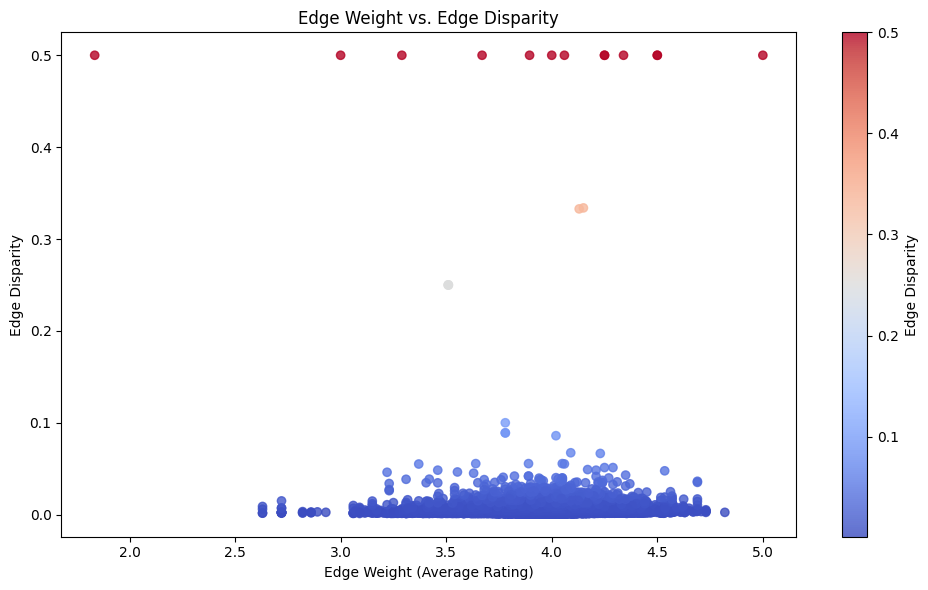

High Disparity Edges:
Edge: ('Activities', 'Games'), Weight: 1.835, Disparity: 0.5
Edge: ('Recreation', 'Sports'), Weight: 4.34, Disparity: 0.5
Edge: ('Comics', 'Graphic Novels'), Weight: 3.895, Disparity: 0.5
Edge: ('Authors', 'European'), Weight: 4.5, Disparity: 0.5
Edge: ('Antiques', 'Collectibles'), Weight: 4.25, Disparity: 0.5
Edge: ('Disciplines', 'Language Arts'), Weight: 5.0, Disparity: 0.5
Edge: ('Body', 'Mind'), Weight: 3.5100000000000002, Disparity: 0.25
Edge: ('Body', 'Spirit'), Weight: 3.5100000000000002, Disparity: 0.25
Edge: ('Mind', 'Spirit'), Weight: 3.5100000000000002, Disparity: 0.25
Edge: ('Childrens poetry', 'Swedish'), Weight: 3.0, Disparity: 0.5
Edge: ('Crafts', 'Hobbies'), Weight: 3.67, Disparity: 0.5
Edge: ('Home', 'House'), Weight: 4.25, Disparity: 0.5
Edge: ('1961-1975', 'Vietnam War'), Weight: 4.5, Disparity: 0.5
Edge: ('AUTOBIOGRAPHY', 'BIOGRAPHY'), Weight: 4.0, Disparity: 0.5
Edge: ('American', 'Fantasy fiction'), Weight: 4.15, Disparity: 0.333869670152855

In [18]:
# Calculate edge disparity using the provided function
def calculate_edge_disparity(graph):
    edge_disparity = {}
    for u, v, data in graph.edges(data=True):
        # Weight of the edge
        edge_weight = data['weight']
        
        # Strength of the connected nodes
        node_u_strength = sum(graph[u][neighbor]['weight'] for neighbor in graph.neighbors(u))
        node_v_strength = sum(graph[v][neighbor]['weight'] for neighbor in graph.neighbors(v))
        
        # Total strength of nodes u and v
        total_strength = node_u_strength + node_v_strength
        
        # Calculate disparity
        disparity = edge_weight / total_strength if total_strength > 0 else 0
        edge_disparity[(u, v)] = disparity
    
    return edge_disparity

# Calculate edge disparity for the network
edge_disparity = calculate_edge_disparity(genre_network_rating)

# Find edges with high disparity
# Define "high disparity" as the top 10% of disparity values
threshold = sorted(edge_disparity.values(), reverse=True)[15]
high_disparity_edges = {edge: value for edge, value in edge_disparity.items() if value >= threshold}

# Plot: Edge Weight vs. Edge Disparity (for all edges)
weights = [genre_network_rating[u][v]['weight'] for u, v in edge_disparity.keys()]
disparities = list(edge_disparity.values())

plt.figure(figsize=(10, 6))
plt.scatter(weights, disparities, alpha=0.8, c=disparities, cmap="coolwarm", label="All Edges")
plt.colorbar(label="Edge Disparity")
plt.xlabel("Edge Weight (Average Rating)")
plt.ylabel("Edge Disparity")
plt.title("Edge Weight vs. Edge Disparity")
plt.tight_layout()
plt.show()
print("High Disparity Edges:")
for edge, disparity in high_disparity_edges.items():
    weight = genre_network_rating[edge[0]][edge[1]]['weight']
    print(f"Edge: {edge}, Weight: {weight}, Disparity: {disparity}")

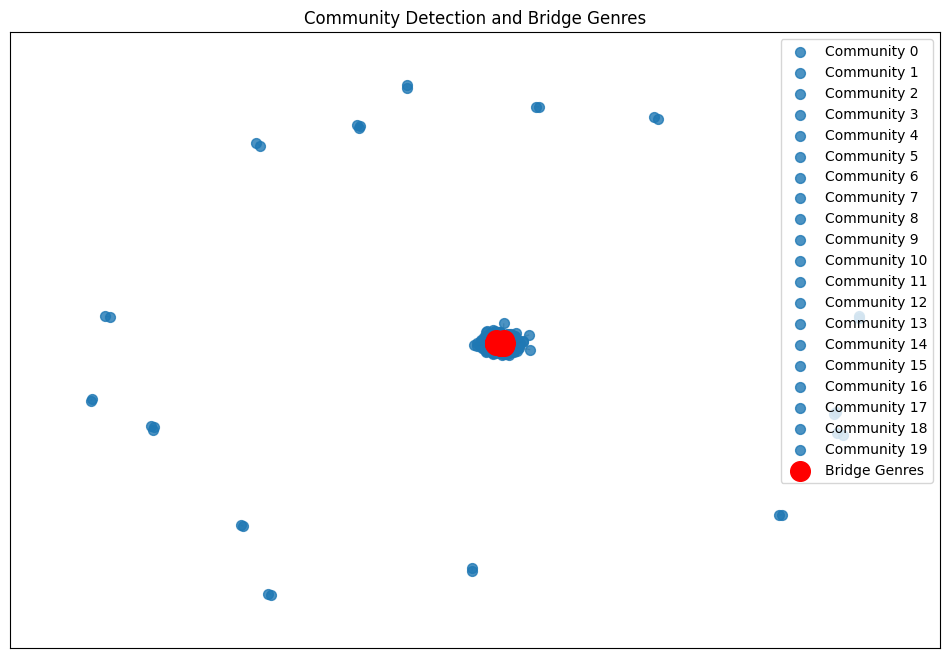

Bridge Genres:
                   Genre  Betweenness Centrality  Community
20            Nonfiction                0.077857          5
5                Fiction                0.057346          0
39               Romance                0.032117          1
11                Novels                0.032009          0
55          Contemporary                0.028890          1
..                   ...                     ...        ...
73              New York                0.002167          1
84              Academic                0.002122          5
40           Anthologies                0.002043          0
8   Fantasy,Supernatural                0.001973          0
69               Animals                0.001957          0

[86 rows x 3 columns]


In [20]:
import networkx as nx
import community as community_louvain  # For Louvain community detection
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Create the Graph (Use your own data here)
# Example: genre_network_rating should be your weighted graph where nodes are genres and weights are based on ratings
# This assumes the graph has already been constructed

# Step 2: Perform Louvain Community Detection
# Assign a community to each node
partition = community_louvain.best_partition(genre_network_rating, weight='weight')

# Add community information as node attributes
for node, community_id in partition.items():
    genre_network_rating.nodes[node]['community'] = community_id

# Step 3: Calculate Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(genre_network_rating, weight='weight', normalized=True)

# Add betweenness centrality as a node attribute
for node, centrality in betweenness_centrality.items():
    genre_network_rating.nodes[node]['betweenness_centrality'] = centrality

# Step 4: Identify Bridge Genres
# Bridge genres will have high betweenness centrality
high_betweenness_threshold = sorted(betweenness_centrality.values(), reverse=True)[int(0.1 * len(betweenness_centrality))]
bridge_genres = {node: centrality for node, centrality in betweenness_centrality.items() if centrality >= high_betweenness_threshold}

# Step 5: Analyze Cluster Membership
# Check which clusters these bridge genres belong to
bridge_genres_df = pd.DataFrame({
    "Genre": list(bridge_genres.keys()),
    "Betweenness Centrality": list(bridge_genres.values()),
    "Community": [partition[node] for node in bridge_genres.keys()]
})

# Step 6: Visualize the Clusters
# Color nodes by their community
pos = nx.spring_layout(genre_network_rating)  # Spring layout for better visualization
plt.figure(figsize=(12, 8))

# Draw nodes, coloring by community
communities = set(partition.values())
for community_id in communities:
    nodes_in_community = [node for node in partition if partition[node] == community_id]
    nx.draw_networkx_nodes(
        genre_network_rating, pos, nodelist=nodes_in_community, 
        node_size=50, label=f"Community {community_id}", alpha=0.8
    )

# Draw edges
nx.draw_networkx_edges(genre_network_rating, pos, alpha=0.3)

# Highlight bridge genres
nx.draw_networkx_nodes(
    genre_network_rating, pos, nodelist=list(bridge_genres.keys()), 
    node_size=200, node_color="red", label="Bridge Genres"
)

plt.title("Community Detection and Bridge Genres")
plt.legend()
plt.show()

# Step 7: Save and Display Results
# Print bridge genres
print("Bridge Genres:")
print(bridge_genres_df.sort_values(by="Betweenness Centrality", ascending=False))

# Save results to a CSV
bridge_genres_df.to_csv("bridge_genres.csv", index=False)


In [21]:
# Check the degree of each node in the graph
node_degrees = dict(genre_network_rating.degree())
low_degree_nodes = {node: degree for node, degree in node_degrees.items() if degree <= 2}

print("Nodes with degree 1 or 2:")
print(low_degree_nodes)


Nodes with degree 1 or 2:
{'Activities': 1, 'Games': 1, 'Fitness': 1, 'Autobiography': 1, 'Recreation': 1, 'Sports': 1, 'Comics': 1, 'Graphic Novels': 1, 'Authors': 1, 'European': 1, 'Antiques': 1, 'Collectibles': 1, 'Disciplines': 1, 'Language Arts': 1, 'Body': 2, 'Mind': 2, 'Spirit': 2, 'Health,Physical Therapy': 1, 'Childrens poetry': 1, 'Swedish': 1, 'Crafts': 1, 'Hobbies': 1, 'Category Romance,Love Inspired': 2, 'Home': 1, 'House': 1, '1961-1975': 1, 'Vietnam War': 1, 'AUTOBIOGRAPHY': 1, 'BIOGRAPHY': 1, 'American': 2, 'Fantasy fiction': 1, 'Engineering': 1, 'Technology': 1, 'Finance': 1, 'Personal': 1, 'Horror tales': 1}
